# <center> Calibrating the QICK for phase coherent readout

### <center> In this demo you will calibrate the QICK clocks to have the same phase.

Before you measure a resonance with your QICK this is the first calibration you should do. It is a calibration for the two synthesizers which belong to the QICK signal generator and the QICK readout, respectively. The two synthesizers are running at the same frequency, but there is initially a constant phase difference $\phi$ between these two synthesizers. Doing this calibration results in you finding that phase difference $\phi$. In your subsequent measurements, you can specify this initial phase difference $\phi$ to compensate for it. From then on, the signal generator can synthesize any frequency and then if you read in data (doing a digital down conversion in the process), the readout will still be phase coherent with respect to the signal generator. 

<center> The angular frequency $\omega = 2 \pi f$ .

<center> Also, $\phi = (\omega t) + \phi_0$. 

<center> So, $\phi = (2 \pi f)*t + \phi_0 $. 

If $f$ goes up linearly, the phase difference will also change linearly (it will either increase or decrease, depending on whether the readout is ahead or behind of the signal generator- this is randomly determined each time the board clocks are initialized). Once the phase hits 360 degrees it cycles back to 0 again. For a readout frequency of interest $f_i$ there is a corresponding phase difference $\phi_i$. In this demonstration we assume $f_i \approx 180$ MHz. You can plot $\phi(f)$ and evaluate $\phi(f_i)=\phi_i$.

In [1]:
# Import the QICK drivers and auxiliary libraries
from qick import *
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load bitstream with custom overlay
soc = QickSoc()

# Print the QICK configuration
print(soc)

out_chs = [1,6,7]
# Set the loopback and monitor DAC channels to be in 1st Nyquist zone mode
for ch in out_chs:
    soc.set_nyquist(ch=ch,nqz=1)


QICK configuration:

	Board: ZCU111

	Global clocks (MHz): DAC fabric 384.000, ADC fabric 384.000, reference 204.800

	Generator switch: 1 to 7

	Averager switch: 2 to 1

	Buffer switch: 2 to 1

	7 DAC channels:
	0:	tile 0, channel 0, fs=6144.000 MHz
	1:	tile 0, channel 1, fs=6144.000 MHz
	2:	tile 0, channel 2, fs=6144.000 MHz
	3:	tile 1, channel 0, fs=6144.000 MHz
	4:	tile 1, channel 1, fs=6144.000 MHz
	5:	tile 1, channel 2, fs=6144.000 MHz
	6:	tile 1, channel 3, fs=6144.000 MHz

	2 ADC channels:
	0:	tile 0, channel 0, fs=3072.000 MHz
	1:	tile 0, channel 1, fs=3072.000 MHz

	Refclk multiplier factors: 30 (DAC), 15 (ADC)
	Frequency resolution step: 1.431 Hz

	7 signal generators: max length 65536 samples

	2 readout blocks

	2 average+buffer blocks: max length 1024 samples (averages), 1024 (decimated buffer)

	tProc: 1048576 words program memory, 4096 words data memory
		program RAM: 65536 bytes



### Hardware Configuration

tProc channel 7   : DAC 229 CH3  <-> Readout channel 0 : ADC 224 CH0

The following are optional:

* tProc channel 6   : DAC 229 CH2       <-> Readout channel 1 : ADC 224 CH1
* tProc channel 1   : DAC 228 CH0(P)    <-> oscilloscope, through a DC-block
* PMOD 0_0 (pin 1 on J48 on the ZCU111) <-> oscilloscope



We are going to drive the DAC outputs in periodic mode, so we only need to specify a short constant waveform and they will continue to run forever.

This is useful for the phase measurement, but it's good to stop the DACs afterwards: for that purpose we define a short program.

In [3]:
def reset_gens(soc):
    """
    Run a minimal tProc program that drives all signal generators with 0's.
    Useful for stopping any periodic outputs that may have been driven by a previous program.
    """
    #"set" commands with nsamp=1 or 2 fail in a strange way: 
    #the signal generator plays the entire waveform memory repeatedly for 10-20 seconds
    #during this time, new "set" commands don't work

    nsamp=3

    prog = QickProgram()
    prog.regwi(1,1,soc.freq2reg(f=200),"freq") # an arbitrary frequency seems preferable to 0?
    prog.regwi(1,4,(0x8<<16) + nsamp,"b01000 -> phrst = 0, stdysel = 1, mode = 0, outsel = 00; generator will consume 16*nsamp DAC values")
    for gen in range(7):
        prog.set(gen+1,1,1,0,0,0,4,0, "t=phase=addr=gain=0")
    prog.end()

    soc.tproc.stop()
    soc.tproc.load_bin_program(prog.compile())
    soc.tproc.start()
reset_gens(soc)

We define the frequency range to be tested, and some helper functions that will process and print the results. For each frequency we will print the measured phase (what we care about), and also the mean magnitude and RMS of the waveform (for debugging - the magnitude should always be much larger than the RMS).

In [4]:
# Output frequency f0_v.
###################
# Try it yourself ! Change the output frequency.
###################

f0_start=100
f0_step=0.000250
expts=40
# expts=1

f0_v = np.arange(0,expts)*f0_step+f0_start

# ADC and DAC have different frequency units, and the frequencies used in the two systems must be exactly equal.
# adcfreq() gives you the closest frequency that will satisfy this condition.
f0_v = soc.adcfreq(f0_v)

def calculate_phase(d):
    [xi,xq] = d
    x = xi +1j*xq

    # Average to improve calibration.
    xavg = np.mean(x)

    # Calculate calibration phase.
    fi = np.remainder(np.angle(xavg,deg=True)+360,360)
    return [fi, np.abs(xavg), np.std(x)]

def print_results(res):
    print("freq_i = %f MHz, "%(f0) +
         "phi_i = (%.2f, %.2f) deg, " % tuple([res[i][0] for i in range(2)]) +
         "mag = (%.2f, %.2f), " % tuple([res[i][1] for i in range(2)]) +
         "RMS = (%.2f, %.2f) ADU" % tuple([res[i][2] for i in range(2)]))
#     print("freq_i = %f MHz, phi_i = (%.2f, %.2f) deg, mag = (%.2f, %.2f), RMS = (%.2f, %.2f) ADU" %(f0,*out_array,*A,*xrms))

### Measurement methods
We are going to make the same measurement in several ways, to demonstrate different ways of running the QICK (and hopefully gain some understanding of what's going on under the hood). You can jump to the analysis at the end at any point to plot the data - all methods write the results to the same array.

For the first two methods, we will have a common Python method - below - that acquires the data, but doesn't load the tProc program.

In [5]:
def measure_phase_decimated(soc, f0, fi0, out_array):
    """
    Measure the phase shift for a given frequency using decimated readout, and write it into the provided array.
    Assumes that the tProc is already loaded with a program that reads the frequency and phase from memory locations 123 and 124.
    """
    soc.tproc.stop()
    
    readout_length = 1000

    f0_dac_int = soc.freq2reg(f=f0) # Frequency of signal generator
    
    soc.tproc.single_write(addr=123, data=f0_dac_int)

    fi0_int = deg2reg(fi0)
    soc.tproc.single_write(addr=124, data=fi0_int)

    # Configure readout.
    for ch in range(2):
        soc.configure_readout(ch=ch, output="product", frequency=f0)
#         soc.config_avg(ch=ch, address=0, length=readout_length, enable=True)
        soc.config_buf(ch=ch, address=0, length=readout_length, enable=True)
    
    # Start tProc.
    soc.tproc.start()

    time.sleep(0.1)
    
    # Get data.
    data = [soc.get_decimated(ch=ch, length=readout_length) for ch in range(2)]
#     print(data)

    # Process data.
    res = [calculate_phase(d) for d in data]

    # Save results.
    out_array[:] = [a[0] for a in res]
    print_results(res)

### Load ASM from text file

First, let's program the tProc from an assembly language file, which needs to be located in the same directory when you run it: `01_phase_calibration.asm`

In [6]:
# Constant, real envelope.
# The length must be at least 16 times the nsamp parameter passed to the signal generators.
xg_i = 30000*np.ones(160)
xg_q = np.zeros(len(xg_i))

# Upload waveform.
for ch in out_chs:
    soc.load_pulse_data(ch=ch,idata=xg_i, qdata=xg_q,addr=0)

# Load program.
soc.tproc.load_bin_program(parser.parse_to_bin("01_phase_calibration.asm"))
# soc.tproc.load_program("01_phase_calibration.asm")

# Output phase.
fi0 = 0
fi_v = np.zeros((2,len(f0_v)))
for ii, f0 in enumerate(f0_v):
    measure_phase_decimated(soc, f0, fi0, fi_v[:,ii])

reset_gens(soc)

freq_i = 100.000000 MHz, phi_i = (247.00, 141.49) deg, mag = (635.25, 633.53), RMS = (1.96, 1.74) ADU
freq_i = 100.000249 MHz, phi_i = (226.46, 120.93) deg, mag = (635.72, 632.86), RMS = (1.91, 1.94) ADU
freq_i = 100.000500 MHz, phi_i = (205.80, 100.28) deg, mag = (636.00, 632.89), RMS = (1.91, 1.81) ADU
freq_i = 100.000750 MHz, phi_i = (185.13, 79.60) deg, mag = (635.94, 632.76), RMS = (1.85, 1.88) ADU
freq_i = 100.001000 MHz, phi_i = (164.46, 58.94) deg, mag = (635.71, 632.90), RMS = (1.88, 1.75) ADU
freq_i = 100.001249 MHz, phi_i = (143.90, 38.38) deg, mag = (635.91, 633.14), RMS = (1.84, 1.80) ADU
freq_i = 100.001500 MHz, phi_i = (123.23, 17.72) deg, mag = (635.95, 633.16), RMS = (1.83, 1.74) ADU
freq_i = 100.001750 MHz, phi_i = (102.56, 357.05) deg, mag = (635.96, 632.93), RMS = (1.86, 1.72) ADU
freq_i = 100.002000 MHz, phi_i = (81.89, 336.38) deg, mag = (635.71, 632.91), RMS = (1.92, 1.81) ADU
freq_i = 100.002251 MHz, phi_i = (61.22, 315.71) deg, mag = (635.82, 633.39), RMS = (1.

### QickProgram

It's usually easier to define the tProc program dynamically in Python, rather than loading it from a separate file. The low-level tool for this is QickProgram.

If you compare `01_phase_calibration.asm` to the commands below, you can see the resemblance; if you convert the QickProgram to .asm format with print(prog) it is very clear.

In [7]:
nsamp = 10

prog = QickProgram()
prog.memri(1,1,123,"freq")
prog.memri(1,2,124,"phase")
prog.regwi(1,3,32000,"gain")
prog.regwi(1,4,nsamp,"nsamp: generator will consume 16*nsamp DAC values.")
prog.regwi(1,5,0x4,"b00100 -> phrst = 0, stdysel = 0, mode = 1, outsel = 00")
prog.bitwi(1,5,5,"<<",16)
prog.bitw(1,4,4,"|",5)
prog.regwi(1,6,0,"start time")
prog.synci(1000)
prog.comment("Set trigger.")
prog.regwi(0,1,0x1,"Send a pulse on pmod 0_0 (pin 1 on J48 on the ZCU111).")
prog.seti(0,0,1,0,"Start the pulse.")
prog.seti(0,0,0,100,"End the pulse after 100 ticks (260 ns).")

prog.comment("Program signal generators in periodic mode.") #TODO: make comments sppear in the printout?
prog.comment("Channels 4, 5, 6, 7 -> DAC 229 CH0/1/2/3.")
for ch in out_chs:
    prog.set(ch,1,1,2,0,3,4,6)
prog.synci(1000)
prog.comment("Set trigger.")
prog.regwi(0,1,0xc000,"Trigger both buffers.")
prog.seti(0,0,1,0,"Start the pulse.")
prog.seti(0,0,0,100,"End the pulse after 100 ticks (260 ns).")
prog.end()

print(prog)

# soc.load_qick_program(prog)
soc.tproc.load_bin_program(prog.compile())


# Constant, real envelope.
# The length must be at least 16 times the nsamp parameter passed to the signal generators.
xg_i = 30000*np.ones(16*nsamp)
xg_q = np.zeros(len(xg_i))

# Upload waveform.
for ch in out_chs:
#     soc.gens[gen].load(addr=0,xin_i=xg_i, xin_q=xg_q)
    soc.load_pulse_data(ch=ch,idata=xg_i, qdata=xg_q,addr=0)

# Output phase.
fi0 = 0

fi_v = np.zeros((2,len(f0_v)))

# Load program.
# soc.tproc.load_program("01_phase_calibration.asm")
for ii, f0 in enumerate(f0_v):
    measure_phase_decimated(soc, f0, fi0, fi_v[:,ii])

reset_gens(soc)


// Program

  memri 1, $1, 123;                             //freq
  memri 1, $2, 124;                             //phase
  regwi 1, $3, 32000;                           //gain
  regwi 1, $4, 10;                              //nsamp: generator will consume 16*nsamp DAC values.
  regwi 1, $5, 4;                               //b00100 -> phrst = 0, stdysel = 0, mode = 1, outsel = 00
  bitwi 1, $5, $5 << 16;
  bitw 1, $4, $4 | $5;
  regwi 1, $6, 0;                               //start time
  synci 1000;
  regwi 0, $1, 1;                               //Send a pulse on pmod 0_0 (pin 1 on J48 on the ZCU111).
  seti 0, 0, $1, 0;                             //Start the pulse.
  seti 0, 0, $0, 100;                           //End the pulse after 100 ticks (260 ns).
  set 1, 1, $1, $2, $0, $3, $4, $6;
  set 6, 1, $1, $2, $0, $3, $4, $6;
  set 7, 1, $1, $2, $0, $3, $4, $6;
  synci 1000;
  regwi 0, $1, 49152;                           //Trigger both buffers.
  seti 0, 0, $1, 0;                

### AveragerProgram
Instead of writing your acquisition code from scratch every time, it is usually easier to use AveragerProgram, which combines the QickProgram functionality with a set of built-in acquisition methods. AveragerProgram can also use the tProc to run the acquisition in a loop, which is much faster.

In [8]:
class SingleFreqProgram(AveragerProgram):
    def __init__(self,cfg):
        super().__init__(cfg)

    def initialize(self):
        cfg=self.cfg   
#         r_freq=self.sreg(0, "freq")   #Get frequency register for res_ch
        self.cfg["adc_lengths"]=[self.cfg["readout_length"]]*2          #add length of adc acquisition to config
        self.cfg["adc_freqs"]=[self.cfg["pulse_freq"]]*2   #add frequency of adc ddc to config
        idata = 30000*np.ones(16*cfg["length"])

        for ch in self.cfg['out_ch']:
            self.add_pulse(ch=ch, name="measure", style='arb', idata = idata)
        
        freq=soc.freq2reg(cfg["pulse_freq"])  # convert frequency to dac frequency (ensuring it is an available adc frequency)
        self.marker(t=0,t1=1) # send a pulse on pmod0_0, for scope trigger
        for ch in self.cfg['out_ch']:
            self.pulse(ch=ch, name="measure", freq=freq, phase=cfg["res_phase"], gain=cfg["pulse_gain"], t=0, play=False) # pre-configure readout pulse

        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        self.synci(200) # give processor time to get ahead of the outputs
        self.trigger_adc(adc1=1, adc2=1,adc_trig_offset=self.cfg["adc_trig_offset"])  # trigger the adc acquisition
        for ch in self.cfg['out_ch']:
            self.pulse(ch=ch, name="measure", play=True,mode=1) # play readout pulse
        self.synci(2000)  # wait for measurement to complete
        self.waiti(0,0) # control should wait until the readout is over

config={"out_ch":out_chs,
        "reps":1, # --Fixed
        "res_phase":deg2reg(0), # --Fixed
        
        "length":10, # [Clock ticks]
        # Try varying length from 10-100 clock ticks
        
        "readout_length":1000, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":32000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 100, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 1000, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":1
        # Try varying soft_avgs from 1 to 200 averages

       }

### Decimated readout
First, let's run the AveragerProgram in the same mode that we were using before: decimated readout, where we save the full waveform. If you increase the value of `soft_avgs`, the AveragerProgram will average multiple waveforms before giving you the results, so the measurement will take longer (past 10, the readout time is noticeable) but the RMS of the waveform will decrease.

In [9]:
res=[]
config['reps'] = 1

# change this from 1 to 50
config['soft_avgs'] = 1

# for f0 in [101]:
for f0 in f0_v:
    config['pulse_freq'] = f0
    prog =SingleFreqProgram(config)
#     print(prog)
    data = prog.acquire_decimated(soc, load_pulses=True, progress=False, debug=False)
#     print(data)
    res.append([calculate_phase(d) for d in data])
    print_results(res[-1])
fi_v=np.array([[a[0] for a in r] for r in res]).T

# print(prog)

freq_i = 100.000000 MHz, phi_i = (247.02, 141.49) deg, mag = (636.17, 633.22), RMS = (2.13, 1.74) ADU
freq_i = 100.000249 MHz, phi_i = (226.47, 120.94) deg, mag = (636.02, 633.27), RMS = (1.88, 2.25) ADU
freq_i = 100.000500 MHz, phi_i = (205.79, 100.27) deg, mag = (636.03, 633.51), RMS = (1.95, 1.73) ADU
freq_i = 100.000750 MHz, phi_i = (185.12, 79.60) deg, mag = (635.89, 633.28), RMS = (1.95, 1.81) ADU
freq_i = 100.001000 MHz, phi_i = (164.46, 58.93) deg, mag = (636.12, 633.52), RMS = (1.85, 1.98) ADU
freq_i = 100.001249 MHz, phi_i = (143.91, 38.38) deg, mag = (636.13, 633.11), RMS = (1.98, 1.75) ADU
freq_i = 100.001500 MHz, phi_i = (123.24, 17.71) deg, mag = (635.89, 633.01), RMS = (1.88, 1.93) ADU
freq_i = 100.001750 MHz, phi_i = (102.57, 357.03) deg, mag = (636.21, 633.67), RMS = (1.88, 1.77) ADU
freq_i = 100.002000 MHz, phi_i = (81.90, 336.37) deg, mag = (636.39, 633.44), RMS = (1.92, 1.86) ADU
freq_i = 100.002251 MHz, phi_i = (61.24, 315.71) deg, mag = (636.03, 633.44), RMS = (2.

### Accumulated readout
Since the demodulated waveform is constant over the acquisition window, we don't really need to save the full waveform. In other words, we should use the QICK's accumulating buffer (which sums the values in the window) instead of the decimated buffer.

Since we now get one number per acquisition, the RMS is now calculated over acquisitions, not over waveform samples.

You should see that a "repetition" takes much less time than a "soft average." Normally, decimated readout is only used for finding the correct window to accumulate over, or for debugging.

In [10]:
# change this from 10 to 1000
config['reps'] = 1000

config['soft_avgs'] = 1
res=[]
for f0 in f0_v:
    config['pulse_freq'] = f0
    prog =SingleFreqProgram(config)
    avg_data = prog.acquire(soc, load_pulses=True, progress=False, debug=False)
    data = [[prog.di_buf[i]/config['readout_length'], prog.dq_buf[i]/config['readout_length']] for i in range(2)]
    res.append([calculate_phase(d) for d in data])
    print_results(res[-1])
fi_v=np.array([[a[0] for a in r] for r in res]).T
reset_gens(soc)


freq_i = 100.000000 MHz, phi_i = (247.02, 141.49) deg, mag = (636.18, 633.44), RMS = (0.13, 0.14) ADU
freq_i = 100.000249 MHz, phi_i = (226.47, 120.94) deg, mag = (636.15, 633.36), RMS = (0.14, 0.14) ADU
freq_i = 100.000500 MHz, phi_i = (205.80, 100.27) deg, mag = (636.10, 633.30), RMS = (0.13, 0.13) ADU
freq_i = 100.000750 MHz, phi_i = (185.13, 79.60) deg, mag = (636.26, 633.30), RMS = (0.13, 0.15) ADU
freq_i = 100.001000 MHz, phi_i = (164.46, 58.93) deg, mag = (636.24, 633.38), RMS = (0.13, 0.14) ADU
freq_i = 100.001249 MHz, phi_i = (143.91, 38.38) deg, mag = (636.09, 633.30), RMS = (0.13, 0.14) ADU
freq_i = 100.001500 MHz, phi_i = (123.24, 17.71) deg, mag = (636.12, 633.37), RMS = (0.13, 0.14) ADU
freq_i = 100.001750 MHz, phi_i = (102.57, 357.04) deg, mag = (636.15, 633.34), RMS = (0.15, 0.13) ADU
freq_i = 100.002000 MHz, phi_i = (81.90, 336.37) deg, mag = (636.16, 633.41), RMS = (0.13, 0.16) ADU
freq_i = 100.002251 MHz, phi_i = (61.23, 315.70) deg, mag = (636.02, 633.48), RMS = (0.

### Summary, and RAveragerProgram
This mode (AveragerProgram with accumulated readout) is one of the typical ways that we run the QICK.

The other way uses RAveragerProgram, which has a tProc program with two nested loops: an inner loop for repetitions (just like AveragerProgram) and an outer loop for sweeping a parameter. Because Python can no longer be the bottleneck limiting the measurement speed, this is often much faster.

However, RAveragerProgram cannot be used for this particular measurement because we need to sweep the frequency of both the DAC and the ADC simultaneously - the Proc can control the DAC frequency, but not the ADC frequency. 

### Analysis
Now we can plot the phase as a function of frequency.

As explained at the beginning, this data can be represented as the sum of a phase offset and a time delay. Over a small frequency range, this looks like a linear dependence on frequency.

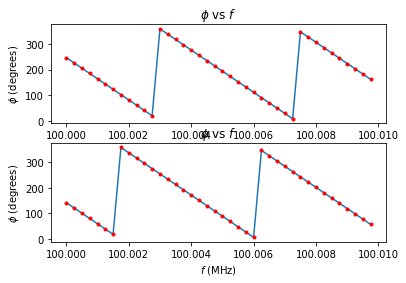

In [11]:
# Plot results.
# plt.figure(2)
fig, axs = plt.subplots(2,1)

for ch in range(2):
    plot = axs[ch]
    plot.plot(f0_v,fi_v[ch])
    plot.plot(f0_v,fi_v[ch], marker='.', linestyle="None",color="Red")
    plot.set_title(r"$\phi$ vs $f$")
    plot.set_ylabel(r"$\phi$ (degrees)")
    plot.set_xlabel(r"$f$ (MHz)")

fig.savefig("images/Phase_calibration.pdf", dpi=350)

For example, if your cavity tone was generated with an IF of 420.9 MHz, you would look at the above table and see that <code> freq_i </code> = 420.9 MHz corresponds to <code> phi_i </code> = 308.7 degrees (that's specific to this board session, for your QICK it will be different). That value of <code> phi_i </code> will be used as the value of the <code> config </code> file parameter associated with the offset phase of the cavity pulse (the parameter is called <code> res_phase </code> in the demo 00_Send_recieve_pulse).

We can try a fit, though the minimization algorithms do not behave very well with the very strongly correlated parameters:

initial estimate: 283.71 deg shift, 229.34 us delay
after minimization: 146.21 deg shift, 251.41 us delay
initial estimate: 300.74 deg shift, 229.34 us delay
after minimization: 150.25 deg shift, 251.41 us delay


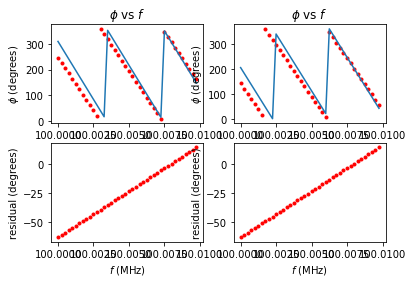

In [12]:
def phase_residuals(data,prediction):
    r = np.remainder(data-prediction+180,360)-180
    return r
    
def phase_model(x, f0):
    return np.remainder(x[0] - 360*x[1]*(f0), 360)

def phase_func(x, *args):
    return phase_residuals(args[0], phase_model(x, f0_v))

from scipy.optimize import least_squares

fig, axs = plt.subplots(2,2)
for ch in range(2):

    slopes = -1*(fi_v[ch,1:]-fi_v[ch,:-1])/(360*(f0_v[1:]-f0_v[:-1]))
#     print(slopes)
    x0 = [0.0,0.0]
    x0[1] = np.median(slopes)
    x0[0] = np.remainder(np.median(phase_residuals(fi_v[ch],phase_model(x0, f0_v))),360)
    print("initial estimate: %.2f deg shift, %.2f us delay"% tuple(x0))

    fit = least_squares(phase_func, x0, args=(fi_v[ch]))
#     fit = least_squares(phase_func, x0, args=(fi_v[ch]), method='lm', x_scale='jac')
#     fit = least_squares(phase_func, x0, args=(fi_v[ch]), method='lm', x_scale=(1,1e-5))
    fit.x[0] = np.remainder(fit.x[0],360)
#     print(fit.status)
    print("after minimization: %.2f deg shift, %.2f us delay"% tuple(fit.x))


    plot = axs[0,ch]
    plot.set_title(r"$\phi$ vs $f$")
    plot.set_ylabel(r"$\phi$ (degrees)")
    plot.set_xlabel(r"$f$ (MHz)")
    plot.plot(f0_v,fi_v[ch], marker='.', linestyle="None",color="Red")
    plot.plot(f0_v, phase_model(fit.x, f0_v))

    plot = axs[1,ch]
    plot.set_ylabel(r"residual (degrees)")
    plot.set_xlabel(r"$f$ (MHz)")
    plot.plot(f0_v, phase_func(fit.x, (fi_v[ch])), marker='.', linestyle="None",color="Red")
#     plot.plot(f0_v, phase_func(x0, (fi_v[ch])), marker='.', linestyle="None",color="Red")


In [13]:
# "product" (0) and "dds" (1) work as advertised; "input" (2) seems identical to "product" and 3 to "dds"
#     soc.readouts[0].outsel_reg = 0

#nsamp=1 or 2 fails in a strange way: 
#the signal generator plays the entire waveform memory repeatedly for 10-20 seconds
#during this time, new "set" commands don't work


# is there ever a reason not to enable both avg and buf?
#         soc.avg_bufs[ch].config_buf(address=0, length=readout_length)
#         soc.avg_bufs[ch].enable_buf()
#         soc.avg_bufs[ch].disable_avg()



#         print(soc.get_accumulated(ch=ch, length=1).T/readout_length, xavg)
